## **Monte Carlo Simulation of Auto Insurance Claims**

<hr style="height:3px;border-width:2;color:teal;background-color:grey">


<font color="C0C0C0"> In this project, I explored the *Insurance Claims Dataset* uploaded to Kaggle by user Sergey Litvinenko. The dataset contained information from about 58,592 auto-insurance policy-holders. 

https://www.kaggle.com/datasets/litvinenko630/insurance-claims/data

For this project, I was interested in the "customer_age", "vehicle_age", and "claim_status" fields.

With this data, I broke the policy-holders into 4 groups: 

    1. Middle aged with old car
    2. Middle aged with new car
    3. Older aged with old car
    4. Older aged with new car

I was interested in the risk associated with each group. So, for each of these groups I used Monte Carlo Simulation to predict useful metrics such as: </font>

    1. Probability of submitting a Claim
    2. Expected Claim Amount
    3. 95% VaR (We could be 95% confident that they won't claim more than this value)
    4. Worst Case Scenario

<hr style="height:3px;border-width:2;color:teal;background-color:grey">


<font color="C0C0C0">First, I used pandas to load in the dataset and get some general information about the data.
Since, we're only interest in the "customer_age", "vehicle_age", and "claim_status" fields, we can crop the original dataframe

In [1]:
import pandas as pd

df = pd.read_csv("Insurance claims data.csv") 

# print(df.columns)
claims_ratio = df['claim_status'].value_counts(normalize=True)
print(claims_ratio)

df = df[["customer_age","vehicle_age", "claim_status"]]
print(df.head())

claim_status
0    0.936032
1    0.063968
Name: proportion, dtype: float64
   customer_age  vehicle_age  claim_status
0            41          1.2             0
1            35          1.8             0
2            44          0.2             0
3            44          0.4             0
4            56          1.0             0


<font color="C0C0C0"> Quickly we can see that from the whole sample, about 6.39% of the policy holders submitted a claim.

<hr style="height:3px;border-width:2;color:teal;background-color:grey">


<font color="C0C0C0"> We also need to add a new column "risk_group" to the dataframe to indicate what risk-group the policy holder is in.

In [2]:
import numpy as np

conditions = [
    (df['customer_age'] <= 55) & (df['vehicle_age'] <= 2),  # Younger + New
    (df['customer_age'] > 55) & (df['vehicle_age'] <= 2),   # Older + New
    (df['customer_age'] <= 55) & (df['vehicle_age'] > 2),   # Younger + Old
    (df['customer_age'] > 55) & (df['vehicle_age'] > 2)     # Older + Old
]

choices = [
    'Middle Aged + New Car', 
    'Older + New Car', 
    'Middle Aged + Old Car', 
    'Older + Old Car'
]

df['risk_group'] = np.select(conditions, choices, default='Unknown')
print(df.sample(3),"\n")

# Creating two pandas series objects to reference in the simulation
group_counts = df['risk_group'].value_counts()   
group_probs = df.groupby('risk_group')['claim_status'].mean()

print("Policy counts by group:\n", group_counts)          
print("\nClaim probabilities by group:\n", group_probs)


       customer_age  vehicle_age  claim_status             risk_group
47192            58          0.2             0        Older + New Car
11069            56          1.8             1        Older + New Car
10676            49          1.2             0  Middle Aged + New Car 

Policy counts by group:
 risk_group
Middle Aged + New Car    38933
Middle Aged + Old Car    14514
Older + New Car           3832
Older + Old Car           1313
Name: count, dtype: int64

Claim probabilities by group:
 risk_group
Middle Aged + New Car    0.066370
Middle Aged + Old Car    0.053466
Older + New Car          0.077505
Older + Old Car          0.069307
Name: claim_status, dtype: float64


<font color="C0C0C0"> If we have this claims data from the past year, how can we use it to predict risk moving forward into the next year? 

Below is a Monte-Carlo simulaton approach where, for each of the four groups, it takes thousands of random samples containing information about both claim frequency and severity. We can now make more educated predictions about the risk and expected claim amounts of each of these risk groups.

We are now ready to run the simulation.

<hr style="height:3px;border-width:2;color:teal;background-color:grey">



**Before writing the simulation function, we need to decide which distributions to sample from. I chose the binomial distribution to estimate frequency and the lognormal distribution to estimate severity.** <font color="C0C0C0">

The binomial distribution is easy to use because the dataset provided a field indicating if that policyholder filed a claim or not, this is modeled by a binomial distribution. Earlier, the parameters for the distribution were estimated from the dataset and stored in the "group_probs" and "group_counts" variables.

Unfortantely the dataset didn't contain information about the severity of each claim, so instead of estimating parameters from the dataset, I chose the mean to be log(5000) and sigma to be 1.2. I chose the lognormal distribution because only deals with positive values and it places more weight on smaller claims which is more realistic. The parameters I chose are arbitrary because it doesn't really matter for this context.

In [3]:
from Custom_Distributions import custom_lognorm_rvs

# Choosing lognormal parameters
lognorm_severity_mu = np.log(5000) 
lognorm_severity_std = 1.2 

def run_simulation_for_group(group_name, num_simulations=10000, deductible=500, limit=25000,normalize=False): 
    total_losses = []

    # binomial dist parameters for each group
    n_policies = group_counts[group_name]
    prob = group_probs[group_name]

    for _ in range(num_simulations):
        n_claims = np.random.binomial(n_policies, prob)
        total_loss = 0

        if n_claims > 0:
            severities = custom_lognorm_rvs(lognorm_severity_mu, lognorm_severity_std, size=n_claims)
            severities = np.clip(severities - deductible, 0, limit)
            total_loss = np.sum(severities)

        if normalize:
            total_loss = total_loss / n_policies

        total_losses.append(total_loss)

    return np.array(total_losses)


<font color="C0C0C0">The simulation samples the frequency of claims, then samples the severity of that number of claims. The sum of the severities from that group is appended to the total_losses list which is returned as a numpy array which contains all the simulated severities.

<hr style="height:3px;border-width:2;color:teal;background-color:grey">


## **Plotting and analyzing the Simulation**

<font color="C0C0C0">After running the simulation we can now plot our findings and extract useful metrics.


--- Middle Aged + New Car (Total Loss) ---
Policies: 38933
Claim Probability: 6.64%
Mean: $19,404,707.07
95% VaR: $20,281,351.15
Worst Case: $21,657,488.23

--- Middle Aged + Old Car (Total Loss) ---
Policies: 14514
Claim Probability: 5.35%
Mean: $5,826,875.00
95% VaR: $6,327,835.43
Worst Case: $7,052,605.54

--- Older + New Car (Total Loss) ---
Policies: 3832
Claim Probability: 7.75%
Mean: $2,231,046.16
95% VaR: $2,534,268.31
Worst Case: $2,929,935.66

--- Older + Old Car (Total Loss) ---
Policies: 1313
Claim Probability: 6.93%
Mean: $683,292.52
95% VaR: $853,051.40
Worst Case: $1,092,607.88

--- Middle Aged + New Car (Loss per Policy) ---
Policies: 38933
Claim Probability: 6.64%
Mean: $498.62
95% VaR: $521.48
Worst Case: $552.51

--- Middle Aged + Old Car (Loss per Policy) ---
Policies: 14514
Claim Probability: 5.35%
Mean: $401.47
95% VaR: $435.00
Worst Case: $487.45

--- Older + New Car (Loss per Policy) ---
Policies: 3832
Claim Probability: 7.75%
Mean: $582.26
95% VaR: $661.44
Wor

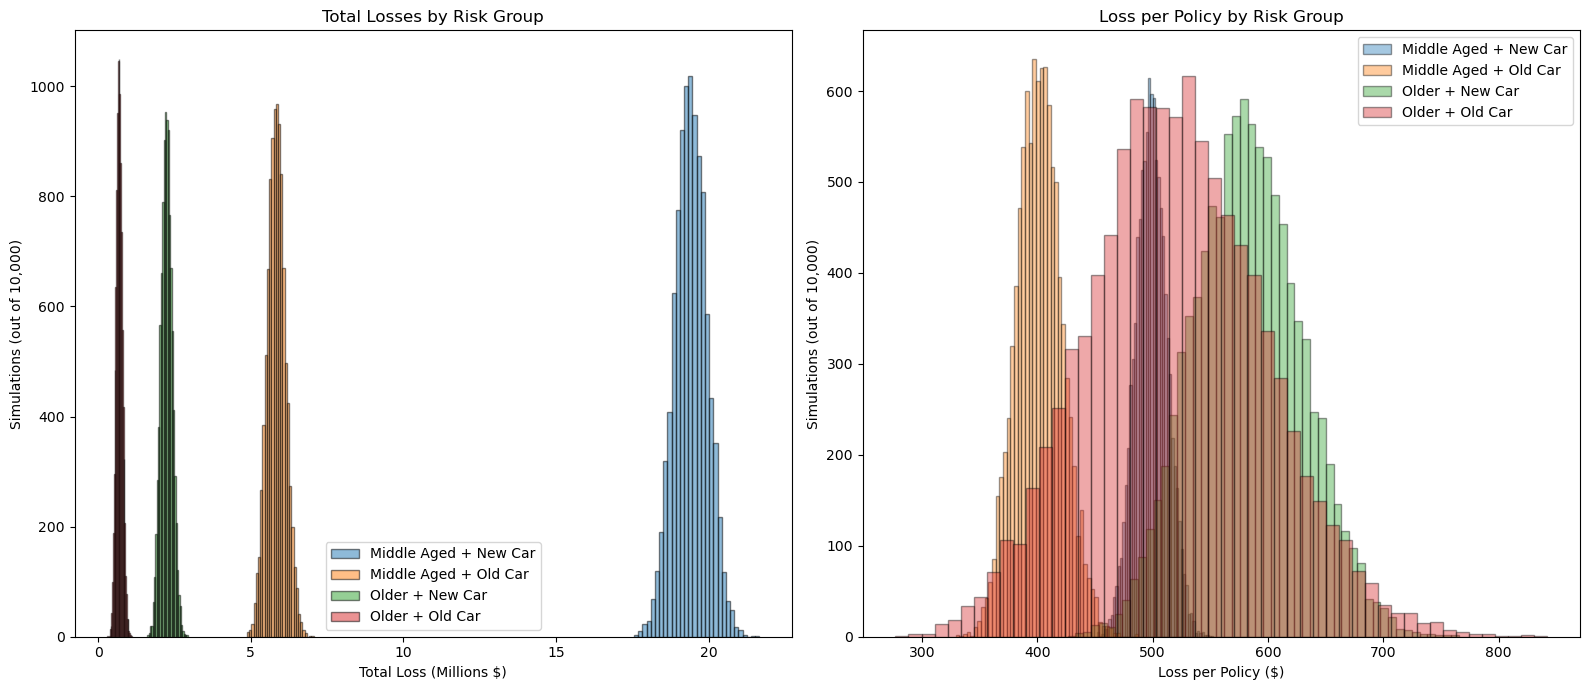

In [4]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16,7))

# Plot 1: Total losses
for group in group_probs.index:
    n_policies = group_counts[group]      # number of policies in the group
    prob = group_probs[group]             # claim probability for the group

    losses = run_simulation_for_group(group, normalize=False)
    axes[0].hist(losses / 1e6, bins=30, edgecolor='k', alpha=0.5, label=group)

# Metrics for total loss
    print(f"\n--- {group} (Total Loss) ---")
    print(f"Policies: {n_policies}")
    print(f"Claim Probability: {prob:.2%}")
    print(f"Mean: ${losses.mean():,.2f}")
    print(f"95% VaR: ${np.percentile(losses, 95):,.2f}")
    print(f"Worst Case: ${losses.max():,.2f}")

axes[0].set_title("Total Losses by Risk Group")
axes[0].set_xlabel("Total Loss (Millions $)")
axes[0].set_ylabel("Simulations (out of 10,000)") # 10000 is a magic number rigt now
axes[0].legend()
axes[0].ticklabel_format(style='plain', axis='x')

# Plot 2: Loss per policy
for group in group_probs.index:
    n_policies = group_counts[group]     
    prob = group_probs[group]

    losses = run_simulation_for_group(group, normalize=True)
    axes[1].hist(losses, bins=50, edgecolor='k', alpha=0.4, label=group)

#metrics for loss per policy
    print(f"\n--- {group} (Loss per Policy) ---")
    print(f"Policies: {n_policies}")
    print(f"Claim Probability: {prob:.2%}")
    print(f"Mean: ${losses.mean():,.2f}")
    print(f"95% VaR: ${np.percentile(losses, 95):,.2f}")
    print(f"Worst Case: ${losses.max():,.2f}")

axes[1].set_title("Loss per Policy by Risk Group")
axes[1].set_xlabel("Loss per Policy ($)")
axes[1].set_ylabel("Simulations (out of 10,000)")
axes[1].legend()

plt.tight_layout()
plt.show()



<hr style="height:3px;border-width:2;color:teal;background-color:grey">


<font color="C0C0C0">We can also combine the four groups and simulate losses across all policy holders.

In [5]:
def run_portfolio_simulation(num_simulations=10000, deductible=500, limit=25000):
    """
    Runs full portfolio simulation across all groups combined.
    Returns an array of total losses for each simulation.
    """
    total_losses = []

    for _ in range(num_simulations):
        total_loss = 0

        for group in group_probs.index:
            n_policies = group_counts[group]
            prob = group_probs[group]
            n_claims = np.random.binomial(n_policies, prob)

            if n_claims > 0:
                severities = custom_lognorm_rvs(lognorm_severity_mu, lognorm_severity_std, size=n_claims)
                severities = np.clip(severities - deductible, 0, limit)
                total_loss += np.sum(severities)

        total_losses.append(total_loss)

    total_losses = np.array(total_losses)

    # Print summary metrics
    print("\n--- Portfolio Metrics ---")
    print(f"Mean Loss: ${total_losses.mean():,.2f}")
    print(f"95% VaR: ${np.percentile(total_losses, 95):,.2f}")
    print(f"Worst Case: ${total_losses.max():,.2f}")

    return total_losses



--- Portfolio Metrics ---
Mean Loss: $28,153,596.49
95% VaR: $29,225,808.58
Worst Case: $31,051,526.93


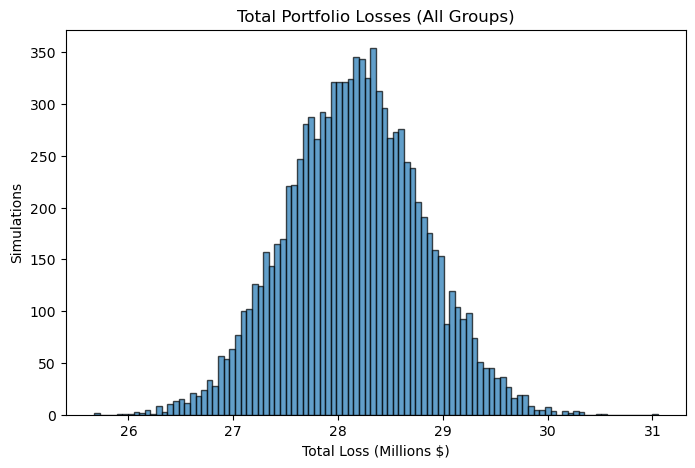

In [6]:
# Run full portfolio simulation
portfolio_losses = run_portfolio_simulation()

# Plot portfolio loss distribution
plt.figure(figsize=(8,5))
plt.hist(portfolio_losses / 1e6, bins=100, edgecolor='k', alpha=0.7)
plt.title("Total Portfolio Losses (All Groups)")
plt.xlabel("Total Loss (Millions $)")
plt.ylabel("Simulations")
plt.show()


<hr style="height:3px;border-width:2;color:teal;background-color:grey">



possible ideas: 

    1. stress testing: create scenarios where frequency or severity goes up/down,  mess with deductible and policy limit
    2. maybe make an excel or streamlit application to adjust things interactively

